**Prepare dataframe for feature selection**
- create list of groups of features

Algorithm:
- split data into training and heldout datasets
- create DFs with all the features from training and heldout datasets
  - normalize data (for logreg)
- iterate over groups of features:
    - for each fold:
        - filter columns from current feature group (training and heldout DF)
        - train model with 5-fold CV and select hyperparameters
        - train model with selected hyperparameters on whole training DF
        - test model on heldout DF
        - save model performance
        - save trained model (parameters?) and results to results_df

In [82]:
%matplotlib inline
import json
import nltk
import pickle
import re
import scipy
import sklearn
import string
import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(width=100)
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
pairs_authorf = pickle.load(open('/home/username/workspace/data/output/_jobs/features/winargs_pairs_post_author_features.pickle','rb'))

In [152]:
pairs_authorf[0]

{'a': {'ancestor': 't1_cnhplrm',
  'author': 'Account9726',
  'comments': [{'approved_by': None,
    'author': 'Account9726',
    'author_flair_css_class': ' points',
    'author_flair_text': '4∆',
    'banned_by': None,
    'body': 'Look at the definition you provided, if we remove the exclusion of things which humans create:\n\n&gt; existing in nature ~~and not made or caused by people~~\n\nSo essentially, by this definition, "natural things" are "things that exist," which is frankly rather meaningless. If one wanted to discuss the results of human activity we would then have to make up a new word which could be redefined by the same argument. \n\nThe whole point of the word is to exclude human activity. If you remove that aspect, it simply ceases to have meaning.',
    'body_html': '&lt;div class="md"&gt;&lt;p&gt;Look at the definition you provided, if we remove the exclusion of things which humans create:&lt;/p&gt;\n\n&lt;blockquote&gt;\n&lt;p&gt;existing in nature &lt;del&gt;and n

In [4]:
heldout_ids = pickle.load(open('/home/username/workspace/data/output/_jobs/heldout_ids.pickle','rb'))

In [6]:
training_pairs = list(filter(lambda x: x['op']['op_name'] not in set(heldout_ids), pairs_authorf))
heldout_pairs = list(filter(lambda x: x['op']['op_name'] in set(heldout_ids), pairs_authorf))
print(len(training_pairs), len(heldout_pairs))

2844 840


In [334]:
training_pairs[0]

{'a': {'ancestor': 't1_cnhplrm',
  'author': 'Account9726',
  'comments': [{'approved_by': None,
    'author': 'Account9726',
    'author_flair_css_class': ' points',
    'author_flair_text': '4∆',
    'banned_by': None,
    'body': 'Look at the definition you provided, if we remove the exclusion of things which humans create:\n\n&gt; existing in nature ~~and not made or caused by people~~\n\nSo essentially, by this definition, "natural things" are "things that exist," which is frankly rather meaningless. If one wanted to discuss the results of human activity we would then have to make up a new word which could be redefined by the same argument. \n\nThe whole point of the word is to exclude human activity. If you remove that aspect, it simply ceases to have meaning.',
    'body_html': '&lt;div class="md"&gt;&lt;p&gt;Look at the definition you provided, if we remove the exclusion of things which humans create:&lt;/p&gt;\n\n&lt;blockquote&gt;\n&lt;p&gt;existing in nature &lt;del&gt;and n

In [137]:
# feature_groups = ['words', 'interplay_root', 'interplay_path',
#                   'traits_sim', 'traits_feat_b', 'traits_feat_p', 'traits_feat_r', 
#                   'traits_feat_dif',
#                   'belief_sim', 'belief_sim_scat', 'belief_sim_spcat', 'belief_sim_sptcat',
#                   'belief_sim_ecat', 'belief_sim_etcat',
#                   'belief_sim_secat', 'belief_sim_setcat']
feature_groups = ['words', 'interplay_root', 'interplay_path',
                  'traits_sim', 'belief_sim']

In [228]:
feature_groups = list(sorted(first.keys(), key=lambda x:x))
feature_groups.remove('delta')
(feature_groups)

['belief_csim',
 'belief_esim',
 'belief_sim_ecatp',
 'belief_sim_ecatr',
 'belief_sim_ecatt',
 'belief_sim_etcatp',
 'belief_sim_etcatr',
 'belief_sim_etcatt',
 'belief_sim_scatr',
 'belief_sim_scatt',
 'belief_sim_scattp',
 'belief_sim_secat',
 'belief_sim_secatp',
 'belief_sim_setcat',
 'belief_sim_setcatp',
 'belief_sim_spcatrp',
 'belief_sim_stcatrp',
 'belief_sim_stcattp',
 'belief_ssim',
 'interplay_path',
 'interplay_root',
 'traits_feat_b',
 'traits_feat_bdif',
 'traits_feat_p',
 'traits_feat_pdif',
 'traits_feat_r',
 'traits_feat_rdif',
 'traits_sim',
 'words']

In [277]:
[print(g) for g in feature_groups]

belief_csim
belief_esim
belief_sim_ecatp
belief_sim_ecatr
belief_sim_ecatt
belief_sim_etcatp
belief_sim_etcatr
belief_sim_etcatt
belief_sim_scatr
belief_sim_scatt
belief_sim_scattp
belief_sim_secat
belief_sim_secatp
belief_sim_setcat
belief_sim_setcatp
belief_sim_spcatrp
belief_sim_stcatrp
belief_sim_stcattp
belief_ssim
interplay_path
interplay_root
traits_feat_b
traits_feat_bdif
traits_feat_p
traits_feat_pdif
traits_feat_r
traits_feat_rdif
traits_sim
words


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [274]:
for k,v in first.items():
    print(k, list(v.keys()))

belief_sim_stcattp ['stctp_Education', 'stctp_Meta', 'stctp_Business', 'stctp_News and Politics', 'stctp_Science', 'stctp_Architecture', 'stctp_Gaming', 'stctp_General', 'stctp_Other', 'stctp_Sports', 'stctp_Locations', 'stctp_Entertainment', 'stctp_Art', 'stctp_Travel', 'stctp_Lifestyle', 'stctp_Adult and NSFW', 'stctp_Hobbies and Interests', 'stctp_Technology', 'stctp_Social Science and Humanities', 'stctp_Law', 'stctp_Music']
words ['path_all', 'op_all', 'root_all']
belief_sim_spcatrp ['scrp_BioShock', 'scrp_Drugs', 'scrp_Dragon Age', 'scrp_King of the Hill', 'scrp_Mythology', 'scrp_Saturday Night Live', 'scrp_Doctor Who', 'scrp_Scotland', 'scrp_Florida', 'scrp_Addictions and Recovery', 'scrp_Scuba Diving', 'scrp_Automobiles', 'scrp_Los Angeles Lakers', 'scrp_Flying', 'scrp_Rock', 'scrp_General', 'scrp_Math', 'scrp_Trailer Park Boys', 'scrp_Web Development', 'scrp_Outdoors', 'scrp_Chrome', 'scrp_Vocaloid', 'scrp_.NET', 'scrp_Adult and NSFW', 'scrp_Big Brother', 'scrp_Rick and Morty'

AttributeError: 'bool' object has no attribute 'keys'

In [450]:
# author_subreddit_vec = pickle.load(open('/home/username/workspace/data/output/_jobs/features/author_subreddit_vec.pickle','rb'))
author_subreddit_vec['huadpe']['raw']


<1x81951 sparse matrix of type '<class 'numpy.float64'>'
	with 81 stored elements in Compressed Sparse Row format>

In [329]:
author_category_vec = pickle.load(open('/home/username/workspace/data/output/_jobs/features/author_category_vec.pickle','rb'))

In [330]:
history = {}
for a,v in author_category_vec.items():
    history[a] = sum(list(v['raw'].data))
len(history)

12287

In [331]:
history['DaystarEld']

14773.0

In [327]:
history_chunks = pickle.load(open('/home/username/workspace/data/output/_jobs/features/history_chunks5.pickle','rb'))

In [369]:
author_history_words_dict = pickle.load(open('/home/username/workspace/data/output/_jobs/features/author_history_words_dict.pickle','rb'))
author_history_words_dict['huadpe']

(2599100, 1304189)

In [434]:
def add_prefix(d, prefix, top_cats=None):
    newd = {}
    for k,v in d.items():
        if top_cats is not None:
            if k in top_cats:
                newd[prefix+'_'+k] = v
        else:
            newd[prefix+'_'+k] = v
    return newd

def prepare_dict(x):
    _dict = defaultdict(dict)

    _dict['chunk'] = min(history[x['op']['op_author']], history[x['a']['author']])
    _dict['chunk_words_min'] = min(author_history_words_dict[x['op']['op_author']][0], author_history_words_dict[x['a']['author']][0])
    _dict['chunk_words_max'] = max(author_history_words_dict[x['op']['op_author']][0], author_history_words_dict[x['a']['author']][0])
    _dict['chunk_words_avg'] = (author_history_words_dict[x['op']['op_author']][0] + author_history_words_dict[x['a']['author']][0]) / 2
    _dict['chunk_stops'] = min(author_history_words_dict[x['op']['op_author']][1], author_history_words_dict[x['a']['author']][1])
      
    ### words/interplay features
    _dict['words']['op_all'] = x['features']['path']['post']['words_op']['all']
    _dict['words']['root_all'] = x['features']['root']['post']['words_a_root']['all']
    _dict['words']['path_all'] = x['features']['path']['post']['words_a_path']['all']
    _dict['interplay_root'].update(x['features']['root']['interplay'])
    _dict['interplay_path'].update(x['features']['path']['interplay'])

# #     ### traits_similarities
    _dict['traits_sim']['bigfive'] = x['features']['author']['bigfive']
    _dict['traits_sim']['percentiles'] = x['features']['author']['percentiles']
    _dict['traits_sim']['raw_scores'] = x['features']['author']['raw_scores']
    _dict['traits_sim']['liwc_scores'] = x['features']['author']['liwc_scores']
    
#     ### traits_features
    _dict['traits_feat_b'].update(dict( [('op'+str(k),v) for k,v in enumerate(x['op']['traits']['bigfive'].tolist()[0])] ))
    _dict['traits_feat_b'].update(dict( [('a'+str(k),v) for k,v in enumerate(x['a']['traits']['bigfive'].tolist()[0])] ))

    _dict['traits_feat_p'].update(dict( [('op'+str(k),v) for k,v in enumerate(x['op']['traits']['percentiles'].tolist()[0])] ))
    _dict['traits_feat_p'].update(dict( [('a'+str(k),v) for k,v in enumerate(x['a']['traits']['percentiles'].tolist()[0])] ))

    _dict['traits_feat_r'].update(dict( [('op'+str(k),v) for k,v in enumerate(x['op']['traits']['raw_scores'].tolist()[0])] ))
    _dict['traits_feat_r'].update(dict( [('a'+str(k),v) for k,v in enumerate(x['a']['traits']['raw_scores'].tolist()[0])] ))


    _dict['traits_feat_bdif'].update(dict( [('bf'+str(i),op-a) for i,(op,a) in enumerate(zip(x['op']['traits']['bigfive'].tolist()[0],x['a']['traits']['bigfive'].tolist()[0]))] ))
    _dict['traits_feat_pdif'].update(dict( [('p'+str(i),op-a) for i,(op,a) in enumerate(zip(x['op']['traits']['percentiles'].tolist()[0],x['a']['traits']['percentiles'].tolist()[0]))] ))
    _dict['traits_feat_rdif'].update(dict( [('r'+str(i),op-a) for i,(op,a) in enumerate(zip(x['op']['traits']['raw_scores'].tolist()[0],x['a']['traits']['raw_scores'].tolist()[0]))] ))
    
#     ### beliefs similarities
    _dict['belief_ssim']['subreddit_tfidf'] = x['features']['author']['subreddit_tfidf']
    _dict['belief_ssim']['subreddit_raw'] = x['features']['author']['subreddit_raw']
    _dict['belief_csim']['category_tfidf'] = x['features']['author']['category_tfidf']
    _dict['belief_csim']['category_raw'] = x['features']['author']['category_raw']
    _dict['belief_esim']['entity_tfidf'] = x['features']['author']['entity_tfidf']
    _dict['belief_esim']['entity_raw'] = x['features']['author']['entity_raw']

#     ### beliefs category similarities
    _dict['belief_sim_scatt'].update(add_prefix(x['features']['author']['subreddit_category_tfidf'], 'sct'))
    _dict['belief_sim_scatr'].update(add_prefix(x['features']['author']['subreddit_category_raw'], 'scr'))

    _dict['belief_sim_scattp'].update(add_prefix(x['features']['author']['subreddit_category_tfidf_pca'], 'sctp'))
    _dict['belief_sim_spcatrp'].update(add_prefix(x['features']['author']['subreddit_category_raw_pca'], 'scrp'))

    _dict['belief_sim_stcattp'].update(add_prefix(x['features']['author']['subreddit_topcategory_tfidf_pca'], 'stctp'))
    _dict['belief_sim_stcatrp'].update(add_prefix(x['features']['author']['subreddit_topcategory_raw_pca'], 'stcrp'))

    _dict['belief_sim_ecatt'].update(add_prefix(x['features']['author']['entity_cat_tfidf'], 'ect'))
    _dict['belief_sim_ecatr'].update(add_prefix(x['features']['author']['entity_cat_raw'], 'ecr'))
    _dict['belief_sim_ecatp'].update(add_prefix(x['features']['author']['entity_cat_pca'], 'ecp'))

    _dict['belief_sim_etcatt'].update(add_prefix(x['features']['author']['entity_topcat_tfidf'], 'ett'))
    _dict['belief_sim_etcatr'].update(add_prefix(x['features']['author']['entity_topcat_raw'], 'etr'))
    _dict['belief_sim_etcatp'].update(add_prefix(x['features']['author']['entity_topcat_pca'], 'etp'))

    _dict['belief_sim_secat'].update(add_prefix(x['features']['author']['sentity_cat'], 'sec'))
    _dict['belief_sim_secatp'].update(add_prefix(x['features']['author']['sentity_cat_pca'], 'secp'))
    _dict['belief_sim_setcat'].update(add_prefix(x['features']['author']['sentity_topcat'], 'set'))
    _dict['belief_sim_setcatp'].update(add_prefix(x['features']['author']['sentity_topcat_pca'], 'setp'))
    
    _dict['delta'] = x['delta']
    return dict(_dict)

training_data = list(map(lambda x: prepare_dict(x), training_pairs))
heldout_data = list(map(lambda x: prepare_dict(x), heldout_pairs))
first = training_data[0]
first.keys()

dict_keys(['traits_feat_pdif', 'belief_sim_ecatp', 'belief_sim_scatr', 'belief_esim', 'belief_ssim', 'chunk_words_max', 'belief_sim_secatp', 'belief_sim_etcatr', 'belief_sim_spcatrp', 'belief_sim_etcatp', 'belief_sim_secat', 'traits_feat_b', 'chunk_words_min', 'interplay_path', 'belief_sim_ecatt', 'traits_feat_bdif', 'delta', 'chunk_stops', 'belief_sim_etcatt', 'words', 'chunk', 'belief_csim', 'traits_sim', 'traits_feat_rdif', 'belief_sim_stcatrp', 'chunk_words_avg', 'belief_sim_ecatr', 'belief_sim_setcat', 'traits_feat_r', 'belief_sim_setcatp', 'belief_sim_stcattp', 'belief_sim_scatt', 'belief_sim_scattp', 'traits_feat_p', 'interplay_root'])

In [453]:
# pairs_df = pd.DataFrame(data)
# training_df = pd.io.json.json_normalize(training_data, sep='_')
# heldout_df = pd.io.json.json_normalize(heldout_data, sep='_')
# print(len(training_df.columns))
training_df.head(1)

,belief_csim_category_raw,belief_csim_category_tfidf,belief_esim_entity_raw,belief_esim_entity_tfidf,belief_sim_ecatp_ecp_.NET,belief_sim_ecatp_ecp_30 Rock,belief_sim_ecatp_ecp_3D Printing,belief_sim_ecatp_ecp_3DS,belief_sim_ecatp_ecp_A Song of Ice and Fire,belief_sim_ecatp_ecp_AI,...,traits_feat_rdif_r7,traits_feat_rdif_r8,traits_feat_rdif_r9,traits_sim_bigfive,traits_sim_liwc_scores,traits_sim_percentiles,traits_sim_raw_scores,words_op_all,words_path_all,words_root_all
0,0.661484,0.151189,0.15276,0.029898,0.0,0,0.0,0,0.0,0,...,-0.222095,0.338394,0.034352,0.969243,0.96515,0.9649,0.970477,279,93,93


In [438]:
# df = training_df.drop(['delta'], axis=1)
# df_norm = (df - df.mean()) / (df.max() - df.min())
# df_norm = df_norm.fillna(0.0)

# X_train = df_norm
X_train = training_df.drop(['delta'], axis=1)
y_train = training_df['delta']
print(X_train.shape)
# X_train.head(5)

(2844, 7263)


In [439]:
# df = heldout_df.drop(['delta'], axis=1)
# df_norm = (df - df.mean()) / (df.max() - df.min())
# df_norm = df_norm.fillna(0.0)

# X_heldout = df_norm
# X_heldout = heldout_df.drop(['delta'], axis=1)
# y_heldout = heldout_df['delta']
# print(X_heldout.shape)
# X_heldout.head(5)
heldout_norm = heldout_df

# heldout_norm = df_norm
# heldout_norm['chunk'] = heldout_df['chunk']
# heldout_norm['chunk_words'] = heldout_df['chunk_words']
# heldout_norm['chunk_stops'] = heldout_df['chunk_stops']
# heldout_norm['delta'] = heldout_df['delta']

In [398]:
heldout_norm['chunk_words'].describe()

count    8.400000e+02
mean     1.698470e+05
std      2.658006e+05
min      1.398000e+03
25%      3.029400e+04
50%      9.152400e+04
75%      1.970850e+05
max      2.599100e+06
Name: chunk_words, dtype: float64

In [399]:
bins = [0, 30000, 90000, 200000, np.inf]
names = ['<30k', '30k-90k', '90k-200k', '200k+']
# X_train['group'] = pd.cut(X_train['chunk'], bins, labels=names)
heldout_norm['group'] = pd.cut(heldout_norm['chunk_words'], bins, labels=names)

In [400]:
heldout_norm.groupby('group').count()

,belief_csim_category_raw,belief_csim_category_tfidf,belief_esim_entity_raw,belief_esim_entity_tfidf,belief_sim_ecatp_ecp_.NET,belief_sim_ecatp_ecp_30 Rock,belief_sim_ecatp_ecp_3D Printing,belief_sim_ecatp_ecp_3DS,belief_sim_ecatp_ecp_A Song of Ice and Fire,belief_sim_ecatp_ecp_AI,...,traits_feat_rdif_r7,traits_feat_rdif_r8,traits_feat_rdif_r9,traits_sim_bigfive,traits_sim_liwc_scores,traits_sim_percentiles,traits_sim_raw_scores,words_op_all,words_path_all,words_root_all
group,,,,,,,,,,,,,,,,,,,,,
<30k,203,203,203,203,203,203,203,203,203,203,...,203,203,203,203,203,203,203,203,203,203
30k-90k,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
90k-200k,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
200k+,205,205,205,205,205,205,205,205,205,205,...,205,205,205,205,205,205,205,205,205,205


In [401]:
groups_delta = heldout_norm[heldout_norm.delta == True].groupby('group')['delta'].count()
groups_nodelta = heldout_norm[heldout_norm.delta == False].groupby('group')['delta'].count()

groups_stats = pd.DataFrame()
groups_stats['delta'] = groups_delta
groups_stats['nodelta'] = groups_nodelta

In [402]:
groups_stats.head(6)

,delta,nodelta
group,,
<30k,106,97
30k-90k,114,102
90k-200k,106,110
200k+,94,111


In [181]:
post_groups = ['words', 'interplay_path', 'interplay_root']
post_columns = []
for g in post_groups:
    post_columns += get_labels(g)

In [253]:
traits_beliefs_columns = []
for g in my_groups:
    traits_beliefs_columns += get_labels(g)
print(traits_beliefs_columns)

['belief_csim_category_raw', 'belief_csim_category_tfidf', 'belief_esim_entity_raw', 'belief_esim_entity_tfidf', 'belief_sim_ecatp_ecp_.NET', 'belief_sim_ecatp_ecp_30 Rock', 'belief_sim_ecatp_ecp_3D Printing', 'belief_sim_ecatp_ecp_3DS', 'belief_sim_ecatp_ecp_A Song of Ice and Fire', 'belief_sim_ecatp_ecp_AI', 'belief_sim_ecatp_ecp_ASMR', 'belief_sim_ecatp_ecp_Accessories', 'belief_sim_ecatp_ecp_Addictions and Recovery', 'belief_sim_ecatp_ecp_Adult Swim', 'belief_sim_ecatp_ecp_Adult and NSFW', 'belief_sim_ecatp_ecp_Adventure Time', 'belief_sim_ecatp_ecp_Age of Empires', 'belief_sim_ecatp_ecp_Agents of S.H.I.E.L.D.', 'belief_sim_ecatp_ecp_Agnosticism', 'belief_sim_ecatp_ecp_Agricultural', 'belief_sim_ecatp_ecp_Air Force', 'belief_sim_ecatp_ecp_Alabama', 'belief_sim_ecatp_ecp_Alaska', 'belief_sim_ecatp_ecp_Alcohol', 'belief_sim_ecatp_ecp_Algorithms', 'belief_sim_ecatp_ecp_Alison Brie', 'belief_sim_ecatp_ecp_Alternative', 'belief_sim_ecatp_ecp_Ambient', 'belief_sim_ecatp_ecp_American Horr

In [260]:
flat_features = ['belief_csim', 'belief_esim', 'belief_ssim',
    'interplay_path', 'interplay_root',
    'traits_sim', 'traits_feat_b', 'traits_feat_bdif',
    'words']

In [405]:
def get_subset(columns):
    _X_train = X_train[columns]
    _y_train = y_train
    heldout = heldout_norm[columns+['group','delta']]
#     _X_test = X_heldout[columns]
#     _y_test = y_heldout
#     return _X_train, _y_train, _X_test, _y_test
    return _X_train, _y_train, heldout
    

def train_model(group, _X_train, _y_train, _X_test, _y_test, feature=None):
    from sklearn import preprocessing

    if _X_train.shape == (_X_train.shape[0],):
        _X_train = _X_train.reshape(-1, 1)
        _X_test = _X_test.reshape(-1, 1)

    lr = Pipeline([
#         ('transformer', Normalizer()),
        ('scaler', preprocessing.StandardScaler()),
        ('logreg', LogisticRegression(penalty='l1'))
    ])        

#     lr = sklearn.linear_model.LogisticRegression(penalty='l1')
    best_model = lr
    best_model.fit(_X_train, _y_train)

    y_pred = best_model.predict(_X_test)
    y_pred_proba = best_model.predict_proba(_X_test)[::,1]
    res = {}

    res['accuracy'] = accuracy_score(_y_test, y_pred)*100
    res['f1'] = f1_score(_y_test, y_pred)*100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    res['roc_auc'] = roc_auc
    precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
    res['precision'] = precision
    res['recall'] = recall
    res['group'] = group
    if feature:
        res['feature'] = feature
    
    return res

def train_model_test_stratified(group, _X_train, _y_train, heldout, feature=None):
    best_model = sklearn.linear_model.LogisticRegression(penalty='l1')
    best_model.fit(_X_train, _y_train)

    results = []
    ### test model separately on each strata
    for strata in heldout.groupby('group'):
        strata_name = strata[0]
        strata_data = strata[1]
        _X_test = strata_data.drop(['group','delta'], axis=1)
        _y_test = strata_data['delta']
        res = {}
    
        y_pred = best_model.predict(_X_test)
        y_pred_proba = best_model.predict_proba(_X_test)[::,1]

        res['accuracy'] = accuracy_score(_y_test, y_pred)*100
        res['f1'] = f1_score(_y_test, y_pred)*100
        false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        res['roc_auc'] = roc_auc
        precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
        res['precision'] = precision
        res['recall'] = recall
        res['group'] = group
        res['strata'] = strata_name
        if feature:
            res['feature'] = feature
        results.append(res)
    
    return results

In [ ]:
results = {}

### process all flat features separately
results['flat features'] = []
for group in flat_features:
    print('Feature group: ' + group)
    columns = get_labels(group)
    for column in columns:
#         print(column)
        res = train_model(group, *get_subset(column), feature=column)
        results['flat features'].append(res)
print('flat feature groups done.')
raise KeyboardInterrupt


In [264]:
flat_features_results_df = pd.DataFrame(results['flat features'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# flat_features_results_df.to_csv('/home/username/workspace/data/output/results/flat_features.csv', encoding='utf-8', index=False)
flat_features_results_df.head(60)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,belief_csim,belief_csim_category_raw,48.333333,47.073171,0.484796,0.483295,0.483333
1,belief_csim,belief_csim_category_tfidf,48.928571,35.098336,0.487194,0.486908,0.489286
2,belief_esim,belief_esim_entity_raw,49.761905,51.605505,0.505935,0.497605,0.497619
3,belief_esim,belief_esim_entity_tfidf,52.261905,57.833859,0.535505,0.524318,0.522619
4,belief_ssim,belief_ssim_subreddit_raw,48.809524,40.934066,0.496502,0.487184,0.488095
5,belief_ssim,belief_ssim_subreddit_tfidf,50.000000,0.000000,0.500000,0.250000,0.500000
6,interplay_path,interplay_path_words_common_all,56.785714,50.879567,0.581392,0.572022,0.567857
7,interplay_path,interplay_path_words_common_content,55.238095,46.892655,0.563268,0.558122,0.552381
8,interplay_path,interplay_path_words_common_stop,56.666667,53.807107,0.595488,0.567704,0.566667
9,interplay_path,interplay_path_words_jaccard_all,46.785714,50.607735,0.464328,0.467068,0.467857


Feature significance p-values

In [455]:
from sklearn.feature_selection import f_regression

sign = f_regression(X_train, y_train, center=True)


In [462]:
sign_df = pd.DataFrame([sign[1]], columns=list(X_train.columns))
sign_df.head(5)

,belief_csim_category_raw,belief_csim_category_tfidf,belief_esim_entity_raw,belief_esim_entity_tfidf,belief_sim_ecatp_ecp_.NET,belief_sim_ecatp_ecp_30 Rock,belief_sim_ecatp_ecp_3D Printing,belief_sim_ecatp_ecp_3DS,belief_sim_ecatp_ecp_A Song of Ice and Fire,belief_sim_ecatp_ecp_AI,...,traits_feat_rdif_r7,traits_feat_rdif_r8,traits_feat_rdif_r9,traits_sim_bigfive,traits_sim_liwc_scores,traits_sim_percentiles,traits_sim_raw_scores,words_op_all,words_path_all,words_root_all
0,0.618434,0.353479,0.012868,0.285194,0.806592,NaN,0.192432,NaN,0.77592,NaN,...,0.431885,0.174709,0.370927,0.135831,0.90986,0.420799,0.165447,1.0,2.537120e-24,6.066363e-14


Best Penalty: l1
Best C: 1.0
Accuracy: 58.69%

F1 Score: 58.64

COnfusion Matrix:
 [[247 173]
 [174 246]]

               precision    recall  f1-score   support

       False       0.59      0.59      0.59       420
        True       0.59      0.59      0.59       420

   micro avg       0.59      0.59      0.59       840
   macro avg       0.59      0.59      0.59       840
weighted avg       0.59      0.59      0.59       840



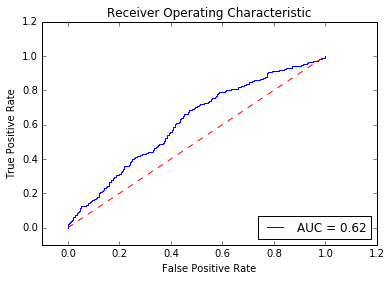

In [200]:
### train on all of features

lr = sklearn.linear_model.LogisticRegression()

penalty = ['l1']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)    
clf = GridSearchCV(lr, hyperparameters, cv=3, n_jobs = -1)
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_heldout)
y_pred_proba = best_model.predict_proba(X_heldout)[::,1]

print("Accuracy: {:.2f}%".format(accuracy_score(y_heldout, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_heldout, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_heldout, y_pred))
print("\n",classification_report(y_heldout, y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_heldout, y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [210]:
def get_labels(k):
    d = first
    return list(map(lambda x: k+'_'+x, pd.io.json.json_normalize(d[k], sep='_').columns))

results = []
models = []

my_groups = [g for g in feature_groups if g not in post_groups]
# for group in feature_groups:
for group in my_groups:
    print('Feature group: ' + group)
#     print(columns)
    columns = get_labels(group)
#     columns = post_columns + get_labels(group)
#     for column in columns:
#         print(column)
    _X_train = X_train[columns]
    _y_train = y_train
    _X_test = X_heldout[columns]
    _y_test = y_heldout

#         print(_X_train.shape)
#         print(len(_X_train.columns))

    lr = sklearn.linear_model.LogisticRegression(penalty='l1')
    best_model = lr
    best_model.fit(_X_train, _y_train)

    y_pred = best_model.predict(_X_test)
    y_pred_proba = best_model.predict_proba(_X_test)[::,1]
    res = {}

    res['accuracy'] = accuracy_score(_y_test, y_pred)*100
    res['f1'] = f1_score(_y_test, y_pred)*100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    res['roc_auc'] = roc_auc
    precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
    res['precision'] = precision
    res['recall'] = recall
    res['group'] = group
#     res['feature'] = column
    results.append(res)



Feature group: belief_csim
Feature group: belief_esim
Feature group: belief_sim_ecatp
Feature group: belief_sim_ecatr
Feature group: belief_sim_ecatt
Feature group: belief_sim_etcatp
Feature group: belief_sim_etcatr
Feature group: belief_sim_etcatt
Feature group: belief_sim_scatr
Feature group: belief_sim_scatt
Feature group: belief_sim_scattp
Feature group: belief_sim_secat
Feature group: belief_sim_secatp
Feature group: belief_sim_setcat
Feature group: belief_sim_setcatp
Feature group: belief_sim_spcatrp
Feature group: belief_sim_stcatrp
Feature group: belief_sim_stcattp
Feature group: belief_ssim
Feature group: traits_feat_b
Feature group: traits_feat_bdif
Feature group: traits_feat_p
Feature group: traits_feat_pdif
Feature group: traits_feat_r
Feature group: traits_feat_rdif
Feature group: traits_sim


In [441]:
# tmp_res = results['supergroup_combinations']
for r in tmp_res:
    

AttributeError: 'list' object has no attribute 'keys'

In [440]:
results.keys()

dict_keys(['post + each group', 'all groups', 'supergroup_combinations', 'all_author_post'])

In [406]:
### 1. train on all the features
### 2. train on all post features
### 3. train on all belief and traits features

# results = []
results['all_author_post'] = []
column_groups = {}
column_groups['all'] = list(X_train.columns)
column_groups['author'] = traits_beliefs_columns
column_groups['post'] = post_columns
for k,columns in column_groups.items():
    res = train_model_test_stratified(k, *get_subset(columns))
    results['all_author_post'].append(res)

len(results['all_author_post'])

3

In [408]:
tmp = []
for g in results['all_author_post']:
    tmp += g

In [452]:
# all_features_results_df = pd.DataFrame(tmp, columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# all_features_results_df.head(25)
print(all_features_results_df.to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
  group &    strata &   accuracy &         f1 &   roc\_auc &  precision &    recall \\
\midrule
   post &      <30k &  56.650246 &  52.173913 &  0.623809 &   0.575692 &  0.571776 \\
   post &   30k-90k &  59.259259 &  58.095238 &  0.642415 &   0.596875 &  0.595975 \\
   post &  90k-200k &  62.962963 &  56.521739 &  0.656003 &   0.637681 &  0.627101 \\
   post &     200k+ &  64.390244 &  57.803468 &  0.666187 &   0.641853 &  0.635327 \\
    all &      <30k &  59.113300 &  56.544503 &  0.610873 &   0.597308 &  0.594923 \\
    all &   30k-90k &  60.185185 &  61.946903 &  0.627193 &   0.600962 &  0.601135 \\
    all &  90k-200k &  53.240741 &  55.895197 &  0.579674 &   0.534356 &  0.533705 \\
    all &     200k+ &  57.073171 &  56.000000 &  0.592869 &   0.572232 &  0.572647 \\
 author &      <30k &  51.231527 &  51.231527 &  0.513130 &   0.513324 &  0.513324 \\
 author &   30k-90k &  57.407407 &  59.649123 &  0.584881 &   0.572755 &  0.572755 \\
 author & 

(2844, 7231)
7231
Best Penalty: l1
Best C: 464.15888336127773
Accuracy: 52.26%

F1 Score: 53.43

COnfusion Matrix:
 [[209 211]
 [190 230]]

               precision    recall  f1-score   support

       False       0.52      0.50      0.51       420
        True       0.52      0.55      0.53       420

   micro avg       0.52      0.52      0.52       840
   macro avg       0.52      0.52      0.52       840
weighted avg       0.52      0.52      0.52       840



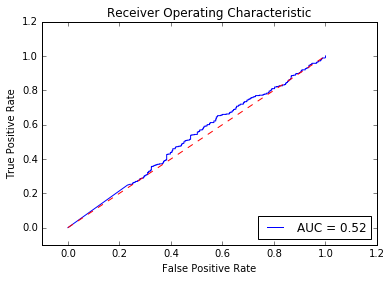

In [255]:
### train on all belief and traits features

columns = traits_beliefs_columns
# columns = post_columns
# columns = post_columns + get_labels(group)
# for column in columns:
# print(columns)
_X_train = X_train[columns]
_y_train = y_train
_X_test = X_heldout[columns]
_y_test = y_heldout

print(_X_train.shape)
print(len(_X_train.columns))

lr = sklearn.linear_model.LogisticRegression()

penalty = ['l1']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)    
clf = GridSearchCV(lr, hyperparameters, cv=3, n_jobs = -1)
best_model = clf.fit(_X_train, _y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(_X_test)
y_pred_proba = best_model.predict_proba(_X_test)[::,1]

print("Accuracy: {:.2f}%".format(accuracy_score(_y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(_y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(_y_test, y_pred))
print("\n",classification_report(_y_test, y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [234]:
list(filter(lambda x: x.startswith('traits_feat_b_'), X_train.columns))

['traits_feat_b_1a0',
 'traits_feat_b_1a1',
 'traits_feat_b_1a2',
 'traits_feat_b_1a3',
 'traits_feat_b_1a4',
 'traits_feat_b_1op0',
 'traits_feat_b_1op1',
 'traits_feat_b_1op2',
 'traits_feat_b_1op3',
 'traits_feat_b_1op4']

In [241]:
### ablation

results_ablation = []

# my_groups = [g for g in feature_groups if g not in post_groups]
for group in feature_groups:
    print('Feature group: ' + group)
    columns = get_labels(group)

    _X_train = X_train.drop(columns, axis=1)
    _y_train = y_train
    _X_test = X_heldout.drop(columns, axis=1)
    _y_test = y_heldout
    
    print('all - '+group, len(_X_train.columns))

    lr = sklearn.linear_model.LogisticRegression(penalty='l1')
    best_model = lr
    best_model.fit(_X_train, _y_train)

    y_pred = best_model.predict(_X_test)
    y_pred_proba = best_model.predict_proba(_X_test)[::,1]
    res = {}

    res['accuracy'] = accuracy_score(_y_test, y_pred)*100
    res['f1'] = f1_score(_y_test, y_pred)*100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    res['roc_auc'] = roc_auc
    precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
    res['precision'] = precision
    res['recall'] = recall
    res['group'] = 'all-'+group
#     res['feature'] = column
    results_ablation.append(res)


Feature group: belief_csim
all - belief_csim 7256
Feature group: belief_esim
all - belief_esim 7256
Feature group: belief_sim_ecatp
all - belief_sim_ecatp 6513
Feature group: belief_sim_ecatr
all - belief_sim_ecatr 6513
Feature group: belief_sim_ecatt
all - belief_sim_ecatt 6513
Feature group: belief_sim_etcatp
all - belief_sim_etcatp 7237
Feature group: belief_sim_etcatr
all - belief_sim_etcatr 7237
Feature group: belief_sim_etcatt
all - belief_sim_etcatt 7237
Feature group: belief_sim_scatr
all - belief_sim_scatr 6513
Feature group: belief_sim_scatt
all - belief_sim_scatt 6513
Feature group: belief_sim_scattp
all - belief_sim_scattp 6513
Feature group: belief_sim_secat
all - belief_sim_secat 6513
Feature group: belief_sim_secatp
all - belief_sim_secatp 6513
Feature group: belief_sim_setcat
all - belief_sim_setcat 7237
Feature group: belief_sim_setcatp
all - belief_sim_setcatp 7237
Feature group: belief_sim_spcatrp
all - belief_sim_spcatrp 6513
Feature group: belief_sim_stcatrp
all - 

(2844, 902)
902
Best Penalty: l1
Best C: 1.0
Accuracy: 60.71%

F1 Score: 60.71

COnfusion Matrix:
 [[255 165]
 [165 255]]

               precision    recall  f1-score   support

       False       0.61      0.61      0.61       420
        True       0.61      0.61      0.61       420

   micro avg       0.61      0.61      0.61       840
   macro avg       0.61      0.61      0.61       840
weighted avg       0.61      0.61      0.61       840



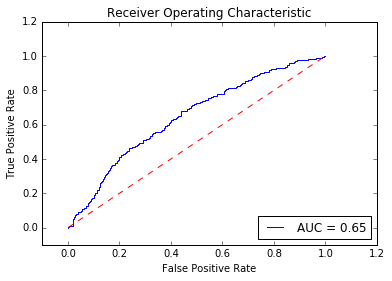

In [258]:
### all top features together

columns=['words_path_all','interplay_path_words_reply_all','interplay_path_words_reply_stop']

top_groups = ['belief_sim_secat', 'traits_feat_pdif',
    'belief_sim_etcatp', 'traits_feat_b', 'traits_feat_bdif', 'traits_feat_rdif']
for g in top_groups:
    columns += get_labels(g)

_X_train = X_train[columns]
_y_train = y_train
_X_test = X_heldout[columns]
_y_test = y_heldout

print(_X_train.shape)
print(len(_X_train.columns))

lr = sklearn.linear_model.LogisticRegression()

penalty = ['l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)    
clf = GridSearchCV(lr, hyperparameters, cv=3, n_jobs = -1)
best_model = clf.fit(_X_train, _y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(_X_test)
y_pred_proba = best_model.predict_proba(_X_test)[::,1]

print("Accuracy: {:.2f}%".format(accuracy_score(_y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(_y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(_y_test, y_pred))
print("\n",classification_report(_y_test, y_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [413]:
results.keys()

dict_keys(['supergroup_combinations', 'all_author_post'])

In [414]:
### process all feature groups
results['all groups'] = []
for group in feature_groups:
#     print('Feature group: ' + group)
#     results[group] = []
#     res = train_model(group, *get_subset(get_labels(group)))
    res = train_model_test_stratified(group, *get_subset(get_labels(group)))
#     results['all groups'].append(res)
    results['all groups'] += res
print('all feature groups done.')

### process each feature group + post features
results['post + each group'] = []
for group in feature_groups:
#     print('Feature group: ' + group)
    columns = post_columns + get_labels(group)
#     res = train_model(group, *get_subset(columns))
    res = train_model_test_stratified(group, *get_subset(columns))
#     results['post + each group'].append(res)
    results['post + each group'] += res
print('each feature group + post done.')

all feature groups done.
each feature group + post done.


In [281]:
results = {}

In [348]:
supergroups = {}
supergroups['post'] = ['words', 'interplay_path', 'interplay_root']
supergroups['traits_flat'] = ['traits_sim']
supergroups['traits_feat_b'] = ['traits_feat_b', 'traits_feat_bdif']
supergroups['traits_feat_p'] = ['traits_feat_p', 'traits_feat_pdif']
supergroups['traits_feat_r'] = ['traits_feat_r', 'traits_feat_rdif']
supergroups['belief_sim'] = ['belief_ssim', 'belief_csim', 'belief_esim']
supergroups['belief_sc'] = ['belief_sim_scatr','belief_sim_scatt','belief_sim_scattp','belief_sim_spcatrp','belief_sim_stcatrp','belief_sim_stcattp']
# supergroups['belief_stc'] = ['belief_sim_stcatrp','belief_sim_stcattp']
supergroups['belief_ec'] = ['belief_sim_ecatp','belief_sim_ecatr','belief_sim_ecatt','belief_sim_etcatp','belief_sim_etcatr','belief_sim_etcatt']
# supergroups['belief_etc'] = ['belief_sim_etcatp','belief_sim_etcatr','belief_sim_etcatt']
supergroups['belief_sec'] = ['belief_sim_secat','belief_sim_secatp','belief_sim_setcat','belief_sim_setcatp']
# supergroups['belief_setc'] = ['belief_sim_setcat','belief_sim_setcatp']
len(supergroups)

9

In [451]:
sum([len(v) for k,v in supergroups.items()])

29

In [349]:
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

supergroup_combinations = combs(list(supergroups.keys()))
supergroup_combinations.remove([])
len(supergroup_combinations)

511

In [308]:
def get_subset(columns):
    _X_train = X_train[columns]
    _y_train = y_train
    _X_test = X_heldout[columns]
    _y_test = y_heldout
    return _X_train, _y_train, _X_test, _y_test
    
def get_subset_drop(columns):
    _X_train = X_train.drop(columns, axis=1)
    _y_train = y_train
    _X_test = X_heldout.drop(columns, axis=1)
    _y_test = y_heldout
    return _X_train, _y_train, _X_test, _y_test

def train_model(group, _X_train, _y_train, _X_test, _y_test, feature=None):
    if _X_train.shape == (_X_train.shape[0],):
        _X_train = _X_train.reshape(-1, 1)
        _X_test = _X_test.reshape(-1, 1)
    lr = sklearn.linear_model.LogisticRegression(penalty='l1')
#     rf = RandomForestClassifier(**get_parameters(_X_train, _y_train))
#     rf = RandomForestClassifier(n_estimators=200)
    best_model = lr
    best_model.fit(_X_train, _y_train)

    y_pred = best_model.predict(_X_test)
    y_pred_proba = best_model.predict_proba(_X_test)[::,1]
    res = {}

    res['accuracy'] = accuracy_score(_y_test, y_pred)*100
    res['f1'] = f1_score(_y_test, y_pred)*100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(_y_test, y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    res['roc_auc'] = roc_auc
    precision, recall, _, _ = precision_recall_fscore_support(_y_test, y_pred, average='macro')
    res['precision'] = precision
    res['recall'] = recall
    res['group'] = group
    if feature:
        res['feature'] = feature
    
    return res

In [392]:
### process group_combinations

results = {}
results['supergroup_combinations'] = []
for combination in supergroup_combinations:
    group_label = ' +'.join([g for g in combination])
    groups = []
    for sg in combination:
        groups += supergroups[sg]
#     print('groups',groups)
    pp.pprint(group_label[:100]+' combination, total groups:'+str(len(groups)))
    columns = []
    for g in groups:
        columns += get_labels(g)
#     print('columns',columns)
#     res = train_model(group_label, *get_subset(columns))
    res = train_model_test_stratified(group_label, *get_subset(columns))
#     results['supergroup_combinations'].append(res)
    results['supergroup_combinations'] += res
print('all feature groups done.')

'belief_ec combination, total groups:6'
'belief_sc combination, total groups:6'
'belief_sc +belief_ec combination, total groups:12'
'traits_feat_p combination, total groups:2'
'traits_feat_p +belief_ec combination, total groups:8'
'traits_feat_p +belief_sc combination, total groups:8'
'traits_feat_p +belief_sc +belief_ec combination, total groups:14'
'belief_sec combination, total groups:4'
'belief_sec +belief_ec combination, total groups:10'
'belief_sec +belief_sc combination, total groups:10'
'belief_sec +belief_sc +belief_ec combination, total groups:16'
'belief_sec +traits_feat_p combination, total groups:6'
'belief_sec +traits_feat_p +belief_ec combination, total groups:12'
'belief_sec +traits_feat_p +belief_sc combination, total groups:12'
'belief_sec +traits_feat_p +belief_sc +belief_ec combination, total groups:18'
'post combination, total groups:3'
'post +belief_ec combination, total groups:9'
'post +belief_sc combination, total groups:9'
'post +belief_sc +belief_ec combinatio

('traits_flat +traits_feat_b +post +traits_feat_p +belief_sc +belief_ec combination, total '
 'groups:20')
'traits_flat +traits_feat_b +post +belief_sec combination, total groups:10'
'traits_flat +traits_feat_b +post +belief_sec +belief_ec combination, total groups:16'
'traits_flat +traits_feat_b +post +belief_sec +belief_sc combination, total groups:16'
'traits_flat +traits_feat_b +post +belief_sec +belief_sc +belief_ec combination, total groups:22'
'traits_flat +traits_feat_b +post +belief_sec +traits_feat_p combination, total groups:12'
('traits_flat +traits_feat_b +post +belief_sec +traits_feat_p +belief_ec combination, total '
 'groups:18')
('traits_flat +traits_feat_b +post +belief_sec +traits_feat_p +belief_sc combination, total '
 'groups:18')
('traits_flat +traits_feat_b +post +belief_sec +traits_feat_p +belief_sc +belief_ec combination, '
 'total groups:24')
'belief_sim combination, total groups:3'
'belief_sim +belief_ec combination, total groups:9'
'belief_sim +belief_sc com

'belief_sim +traits_flat +post +belief_sec +traits_feat_p +belief_sc combination, total groups:19'
('belief_sim +traits_flat +post +belief_sec +traits_feat_p +belief_sc +belief_ec combination, '
 'total groups:25')
'belief_sim +traits_flat +traits_feat_b combination, total groups:6'
'belief_sim +traits_flat +traits_feat_b +belief_ec combination, total groups:12'
'belief_sim +traits_flat +traits_feat_b +belief_sc combination, total groups:12'
'belief_sim +traits_flat +traits_feat_b +belief_sc +belief_ec combination, total groups:18'
'belief_sim +traits_flat +traits_feat_b +traits_feat_p combination, total groups:8'
'belief_sim +traits_flat +traits_feat_b +traits_feat_p +belief_ec combination, total groups:14'
'belief_sim +traits_flat +traits_feat_b +traits_feat_p +belief_sc combination, total groups:14'
('belief_sim +traits_flat +traits_feat_b +traits_feat_p +belief_sc +belief_ec combination, total '
 'groups:20')
'belief_sim +traits_flat +traits_feat_b +belief_sec combination, total gr

('traits_feat_r +traits_feat_b +post +belief_sec +traits_feat_p +belief_ec combination, total '
 'groups:19')
('traits_feat_r +traits_feat_b +post +belief_sec +traits_feat_p +belief_sc combination, total '
 'groups:19')
('traits_feat_r +traits_feat_b +post +belief_sec +traits_feat_p +belief_sc +belief_ec '
 'combination, total groups:25')
'traits_feat_r +traits_flat combination, total groups:3'
'traits_feat_r +traits_flat +belief_ec combination, total groups:9'
'traits_feat_r +traits_flat +belief_sc combination, total groups:9'
'traits_feat_r +traits_flat +belief_sc +belief_ec combination, total groups:15'
'traits_feat_r +traits_flat +traits_feat_p combination, total groups:5'
'traits_feat_r +traits_flat +traits_feat_p +belief_ec combination, total groups:11'
'traits_feat_r +traits_flat +traits_feat_p +belief_sc combination, total groups:11'
'traits_feat_r +traits_flat +traits_feat_p +belief_sc +belief_ec combination, total groups:17'
'traits_feat_r +traits_flat +belief_sec combination

'traits_feat_r +belief_sim +post +traits_feat_p +belief_sc +belief_ec combination, total groups:22'
'traits_feat_r +belief_sim +post +belief_sec combination, total groups:12'
'traits_feat_r +belief_sim +post +belief_sec +belief_ec combination, total groups:18'
'traits_feat_r +belief_sim +post +belief_sec +belief_sc combination, total groups:18'
'traits_feat_r +belief_sim +post +belief_sec +belief_sc +belief_ec combination, total groups:24'
'traits_feat_r +belief_sim +post +belief_sec +traits_feat_p combination, total groups:14'
('traits_feat_r +belief_sim +post +belief_sec +traits_feat_p +belief_ec combination, total '
 'groups:20')
('traits_feat_r +belief_sim +post +belief_sec +traits_feat_p +belief_sc combination, total '
 'groups:20')
('traits_feat_r +belief_sim +post +belief_sec +traits_feat_p +belief_sc +belief_ec combination, '
 'total groups:26')
'traits_feat_r +belief_sim +traits_feat_b combination, total groups:7'
'traits_feat_r +belief_sim +traits_feat_b +belief_ec combinatio

('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +belief_ec combination, '
 'total groups:18')
('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +belief_sc combination, '
 'total groups:18')
('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +belief_sc +belief_ec '
 'combination, total groups:24')
('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +traits_feat_p combination, '
 'total groups:14')
('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +traits_feat_p +belief_ec '
 'combination, total groups:20')
('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +traits_feat_p +belief_sc '
 'combination, total groups:20')
('traits_feat_r +belief_sim +traits_flat +traits_feat_b +belief_sec +traits_feat_p +belief_sc '
 '+belief_ combination, total groups:26')
'traits_feat_r +belief_sim +traits_flat +traits_feat_b +post combination, total groups:11'
('traits_feat_r +belief_sim +traits_flat +

In [394]:
# combinations_results_df = pd.DataFrame(results['supergroup_combinations'], columns=['group', 'strata', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
combinations_results_df.to_csv('/home/username/workspace/data/output/results/strata_words_winargs_combinations_lr.csv', encoding='utf-8', index=False)
# combinations_results_df.sort_values(by=['index'], inplace=True, ascending=False)
# combinations_results_df.head(50)
# combinations_results_df.sort_values('accuracy').drop_duplicates(['group'],keep='last')

In [354]:
pickle.dump(results, open('/home/username/workspace/data/output/results/_supergroup_combinations_results.pickle','wb'))

In [319]:
from sklearn.feature_selection import RFE

# clf = RandomForestClassifier()
clf = sklearn.linear_model.LogisticRegression(penalty='l1')
rfe = RFE(clf, 100)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 100
Selected Features: [False False False ... False  True  True]
Feature Ranking: [269  14 465 ... 495   1   1]


In [320]:
best_lr = list(X_train.columns[fit.support_])
len(best_lr)

100

In [322]:
best_lr

['belief_sim_ecatp_ecp_Cats',
 'belief_sim_ecatp_ecp_Comedy',
 'belief_sim_ecatp_ecp_Computer Science and IT',
 'belief_sim_ecatp_ecp_DIY',
 'belief_sim_ecatp_ecp_Drugs',
 'belief_sim_ecatp_ecp_Dungeons & Dragons',
 'belief_sim_ecatp_ecp_Entertainment',
 'belief_sim_ecatp_ecp_Health',
 'belief_sim_ecatp_ecp_India',
 'belief_sim_ecatp_ecp_Linux',
 'belief_sim_ecatp_ecp_MMA',
 'belief_sim_ecatp_ecp_Photography',
 'belief_sim_ecatp_ecp_Pokemon',
 'belief_sim_ecatp_ecp_Portland',
 'belief_sim_ecatp_ecp_Rick and Morty',
 'belief_sim_ecatp_ecp_Self-help and Motivation',
 'belief_sim_ecatp_ecp_Star Trek',
 'belief_sim_ecatp_ecp_Vegan and Vegetarian',
 'belief_sim_ecatp_ecp_Web Design',
 'belief_sim_ecatp_ecp_iOS',
 'belief_sim_ecatr_ecr_Baseball',
 'belief_sim_ecatr_ecr_Dating',
 'belief_sim_ecatr_ecr_Democrat',
 'belief_sim_ecatr_ecr_Jobs and Careers',
 'belief_sim_ecatr_ecr_Keto',
 'belief_sim_ecatr_ecr_Marijuana',
 'belief_sim_ecatr_ecr_Overwatch',
 'belief_sim_ecatr_ecr_Philosophy',
 'bel

In [321]:
res = train_model('best', *get_subset(best_lr))
res

{'accuracy': 57.97619047619048,
 'f1': 57.21212121212121,
 'group': 'best',
 'precision': 0.5798637718177948,
 'recall': 0.5797619047619047,
 'roc_auc': 0.6159920634920635}

In [318]:
### combinations results for LogReg
# combinations_results_df = pd.DataFrame(results['supergroup_combinations'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
combinations_results_df.to_csv('/home/username/workspace/data/output/results/winargs_combinations_lr.csv', encoding='utf-8', index=False)
combinations_results_df.sort_values(by=['roc_auc'], inplace=True, ascending=False)
combinations_results_df.head(5)

,group,feature,accuracy,f1,roc_auc,precision,recall
111,traits_flat +traits_feat_b +post,NaN,61.547619,59.875776,0.661933,0.616284,0.615476
47,traits_feat_b +post,NaN,61.428571,59.500000,0.659768,0.615332,0.614286
239,belief_sim +traits_flat +traits_feat_b +post,NaN,60.476190,58.080808,0.658832,0.606148,0.604762
175,belief_sim +traits_feat_b +post,NaN,60.952381,58.585859,0.657234,0.610973,0.609524
56,traits_feat_b +post +belief_sec +belief_ec,NaN,60.952381,60.859189,0.652670,0.609526,0.609524


In [428]:
filtered_df = combinations_results_dfx[combinations_results_df.group.map(lambda x: 'post' not in x)]

In [431]:
filtered_df.head()

,group,strata,feature,accuracy,f1,roc_auc,precision,recall
0,belief_ec,<30k,NaN,49.753695,55.263158,0.534429,0.492765,0.493046
1,belief_ec,30k-90k,NaN,53.703704,56.140351,0.552804,0.535604,0.535604
2,belief_ec,90k-200k,NaN,48.148148,48.148148,0.504331,0.481647,0.481647
3,belief_ec,200k+,NaN,52.195122,51.960784,0.544518,0.525120,0.525158
4,belief_sc,<30k,NaN,51.231527,55.605381,0.527427,0.509143,0.508948


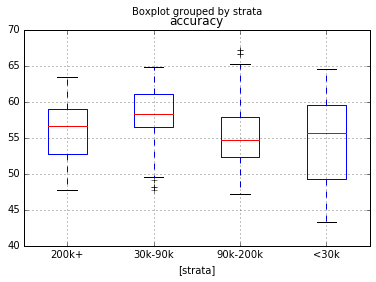

In [432]:
combinations_results_df.boxplot(column='accuracy', by=['strata'])

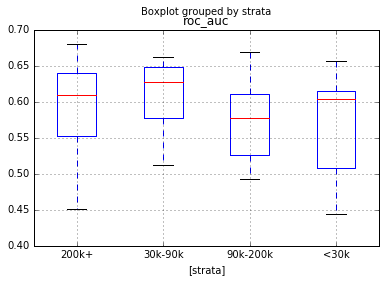

In [433]:
combinations_results_df.boxplot(column='roc_auc', by=['strata'])

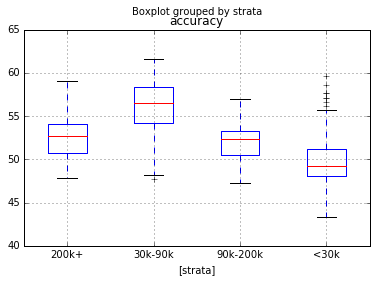

In [429]:
filtered_df.boxplot(column='accuracy', by=['strata'])

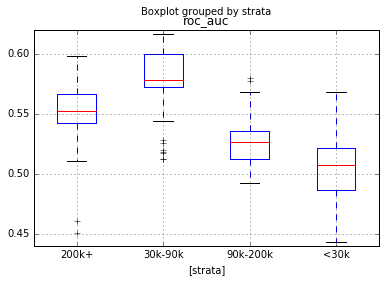

In [430]:
filtered_df.boxplot(column='roc_auc', by=['strata'])

In [316]:
### run next - save combinations results for RF
# rf_combinations_results_df = pd.DataFrame(results['supergroup_combinations'], columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# rf_combinations_results_df.to_csv('/home/username/workspace/data/output/results/winargs_combinations_rf.csv', encoding='utf-8', index=False)
rf_combinations_results_df.sort_values(by=['roc_auc'], inplace=True, ascending=False)
rf_combinations_results_df.head(5)

,group,feature,accuracy,f1,roc_auc,precision,recall
247,belief_sim +traits_flat +traits_feat_b +post +...,NaN,61.071429,59.975520,0.659671,0.611047,0.610714
48,traits_feat_b +post +belief_ec,NaN,61.428571,60.391198,0.658095,0.614600,0.614286
56,traits_feat_b +post +belief_sec +belief_ec,NaN,60.357143,59.831122,0.657806,0.603643,0.603571
87,traits_flat +post +belief_sec,NaN,60.952381,59.705160,0.657421,0.609945,0.609524
55,traits_feat_b +post +belief_sec,NaN,60.595238,59.878788,0.656190,0.606088,0.605952


In [411]:
results.keys()

dict_keys(['supergroup_combinations', 'all_author_post'])

In [180]:
# flat_features_results_df = pd.DataFrame(results, columns=['group', 'feature', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# flat_features_results_df.to_csv('/home/username/workspace/data/output/results/flat_features.csv', encoding='utf-8', index=False)
flat_features_results_df.head(40)

,group,feature,accuracy,f1,roc_auc,precision,recall
0,words,words_op_all,50.000000,0.000000,0.500000,0.250000,0.500000
1,words,words_path_all,59.166667,51.622003,0.627925,0.601545,0.591667
2,words,words_root_all,55.238095,46.438746,0.573098,0.558720,0.552381
3,interplay_root,interplay_root_words_common_all,53.571429,46.721311,0.535354,0.538243,0.535714
4,interplay_root,interplay_root_words_common_content,50.952381,40.974212,0.517528,0.510753,0.509524
5,interplay_root,interplay_root_words_common_stop,54.285714,51.269036,0.549323,0.543524,0.542857
6,interplay_root,interplay_root_words_jaccard_all,50.714286,54.901961,0.499776,0.507398,0.507143
7,interplay_root,interplay_root_words_jaccard_content,50.476190,56.846473,0.515383,0.505217,0.504762
8,interplay_root,interplay_root_words_jaccard_stop,53.452381,52.834741,0.541471,0.534548,0.534524
9,interplay_root,interplay_root_words_op_all,52.500000,47.843137,0.530573,0.525823,0.525000


In [214]:
# feature_groups_results_df = pd.DataFrame(results, columns=['group', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
# feature_groups_results_df.to_csv('/home/username/workspace/data/output/results/feature_groups.csv', encoding='utf-8', index=False)
feature_groups_results_df.head(40)

,group,accuracy,f1,roc_auc,precision,recall
0,belief_csim,48.452381,43.839170,0.461729,0.484095,0.484524
1,belief_esim,49.642857,51.435132,0.505981,0.496409,0.496429
2,belief_sim_ecatp,51.071429,54.585635,0.526446,0.510977,0.510714
3,belief_sim_ecatr,49.404762,54.931071,0.498067,0.493667,0.494048
4,belief_sim_ecatt,52.738095,60.963618,0.528662,0.533294,0.527381
5,belief_sim_etcatp,52.261905,53.208868,0.527942,0.522656,0.522619
6,belief_sim_etcatr,50.833333,56.480506,0.504575,0.508935,0.508333
7,belief_sim_etcatt,54.047619,60.206186,0.530408,0.544765,0.540476
8,belief_sim_scatr,52.142857,56.304348,0.512914,0.522235,0.521429
9,belief_sim_scatt,52.023810,56.620022,0.514235,0.521190,0.520238


In [415]:
results.keys()

dict_keys(['post + each group', 'all groups', 'supergroup_combinations', 'all_author_post'])

In [417]:
# all_groups_results_df = pd.DataFrame(results['all groups'], columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
all_groups_results_df.to_csv('/home/username/workspace/data/output/results/strata_words_all_groups.csv', encoding='utf-8', index=False)
# all_groups_results_df.groupby('group').head(50)
all_groups_results_df.sort_values('accuracy').drop_duplicates(['group'],keep='last')

,group,strata,accuracy,f1,roc_auc,precision,recall
1,belief_csim,30k-90k,50.462963,45.685279,0.498452,0.511686,0.511094
75,belief_ssim,200k+,51.219512,35.897436,0.499377,0.495037,0.495783
99,traits_feat_pdif,200k+,52.195122,51.485149,0.542314,0.524246,0.524343
58,belief_sim_setcatp,90k-200k,52.777778,52.777778,0.530575,0.527959,0.527959
35,belief_sim_scatr,200k+,53.170732,51.515152,0.533592,0.532321,0.532538
6,belief_esim,90k-200k,53.240741,47.120419,0.540952,0.531881,0.530446
8,belief_sim_ecatp,<30k,53.694581,62.096774,0.560105,0.533422,0.528156
111,traits_sim,200k+,54.146341,0.000000,0.499952,0.270732,0.500000
105,traits_feat_rdif,30k-90k,54.166667,52.631579,0.561920,0.545672,0.545150
25,belief_sim_etcatr,30k-90k,54.166667,63.197026,0.505504,0.536489,0.529670


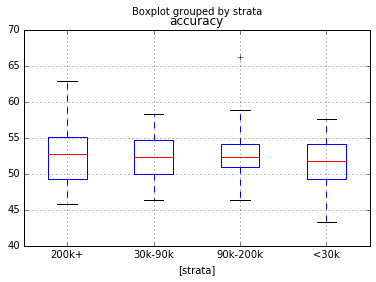

In [424]:
all_groups_results_df.boxplot(column='accuracy', by=['strata'])

In [420]:
post_feature_groups_results_df = pd.DataFrame(results['post + each group'], columns=['group', 'strata', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
post_feature_groups_results_df.to_csv('/home/username/workspace/data/output/results/strata_words_post_feature_groups.csv', encoding='utf-8', index=False)
post_feature_groups_results_df.head(40)

,group,strata,accuracy,f1,roc_auc,precision,recall
0,belief_csim,<30k,58.620690,54.838710,0.623322,0.595173,0.591082
1,belief_csim,30k-90k,59.259259,58.095238,0.643189,0.596875,0.595975
2,belief_csim,90k-200k,62.962963,56.521739,0.654031,0.637681,0.627101
3,belief_csim,200k+,65.853659,59.302326,0.658999,0.657632,0.649655
4,belief_esim,<30k,58.128079,55.026455,0.620016,0.588253,0.585489
5,belief_esim,30k-90k,60.648148,59.330144,0.643447,0.611440,0.610165
6,belief_esim,90k-200k,62.962963,56.043956,0.655146,0.639098,0.626930
7,belief_esim,200k+,62.926829,54.761905,0.667338,0.627605,0.618555
8,belief_sim_ecatp,<30k,58.620690,55.789474,0.643941,0.592787,0.590206
9,belief_sim_ecatp,30k-90k,59.259259,58.878505,0.663743,0.595172,0.594943


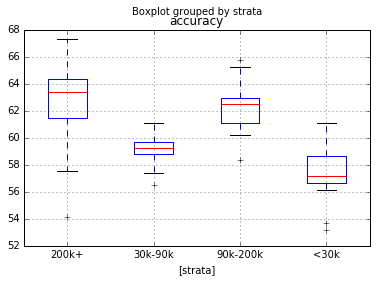

In [425]:
post_feature_groups_results_df.boxplot(column='accuracy', by=['strata'])

In [212]:
# traits_beliefs_df = pd.DataFrame(results, columns=['group', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
post_feature_groups_results_df.to_csv('/home/username/workspace/data/output/results/traits_beliefs.csv', encoding='utf-8', index=False)
traits_beliefs_df.head(40)

,group,accuracy,f1,roc_auc,precision,recall
0,belief_csim,48.452381,43.839170,0.461723,0.484095,0.484524
1,belief_esim,49.642857,51.435132,0.505986,0.496409,0.496429
2,belief_sim_ecatp,51.071429,54.585635,0.526451,0.510977,0.510714
3,belief_sim_ecatr,49.404762,54.931071,0.498067,0.493667,0.494048
4,belief_sim_ecatt,52.738095,60.963618,0.528668,0.533294,0.527381
5,belief_sim_etcatp,52.261905,53.208868,0.527925,0.522656,0.522619
6,belief_sim_etcatr,50.833333,56.480506,0.504569,0.508935,0.508333
7,belief_sim_etcatt,54.047619,60.206186,0.530408,0.544765,0.540476
8,belief_sim_scatr,52.142857,56.304348,0.512920,0.522235,0.521429
9,belief_sim_scatt,52.023810,56.620022,0.514235,0.521190,0.520238


In [245]:
# ablation_df = pd.DataFrame(results_ablation, columns=['group', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
ablation_df.to_csv('/home/username/workspace/data/output/results/ablation.csv', encoding='utf-8', index=False)
ablation_df.head(40)

,group,accuracy,f1,roc_auc,precision,recall
0,all-belief_csim,58.333333,58.333333,0.616933,0.583333,0.583333
1,all-belief_esim,58.690476,58.641240,0.616786,0.586905,0.586905
2,all-belief_sim_ecatp,58.928571,58.879619,0.618991,0.589286,0.589286
3,all-belief_sim_ecatr,58.809524,58.907363,0.618311,0.588097,0.588095
4,all-belief_sim_ecatt,58.571429,58.472554,0.615306,0.585716,0.585714
5,all-belief_sim_etcatp,58.571429,58.767773,0.615340,0.585722,0.585714
6,all-belief_sim_etcatr,59.047619,59.241706,0.618152,0.590484,0.590476
7,all-belief_sim_etcatt,59.285714,59.188544,0.617976,0.592859,0.592857
8,all-belief_sim_scatr,59.642857,59.690844,0.617126,0.596429,0.596429
9,all-belief_sim_scatt,59.166667,59.408284,0.618333,0.591680,0.591667


In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

logreg = LogisticRegression(penalty='l1')
rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
print(len(X_train.columns.drop(['delta'])))
print(len(rfecv.support_))

for x in list(zip(rfecv.support_, X_train.columns.drop(['delta']))):
    if x[0]:
        print(x)

In [ ]:
#     penalty = ['l1']
#     C = np.logspace(0, 4, 10)
#     hyperparameters = dict(C=C, penalty=penalty)    
#     clf = GridSearchCV(lr, hyperparameters, cv=3, n_jobs = -1)
#     best_model = clf.fit(_X_train, _y_train)

#     print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
#     print('Best C:', best_model.best_estimator_.get_params()['C'])
    
#     models.append((group, best_model))


(2844, 1490)
1490
Accuracy: 50.71%

F1 Score: 54.70

COnfusion Matrix:
 [[176 244]
 [170 250]]

               precision    recall  f1-score   support

       False       0.51      0.42      0.46       420
        True       0.51      0.60      0.55       420

   micro avg       0.51      0.51      0.51       840
   macro avg       0.51      0.51      0.50       840
weighted avg       0.51      0.51      0.50       840



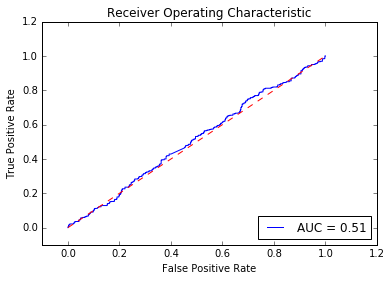

In [27]:
columns = get_labels('belief_sim_scat')
X_train = X_train[columns]
y_train = y_train
X_test = X_heldout[columns]
y_test = y_heldout

print(X_train.shape)
print(len(X_train.columns))

# X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n",classification_report(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = clf.predict_proba(X_test)[::,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()